# 0. Setup

In [14]:
import numpy as np
from numpy.testing import assert_almost_equal
import pandas as pd
from matplotlib import pyplot as plt


In [99]:
### Helper functions

def is_square(m):
    assert m.shape[0] == m.shape[1]

def covariance_correct(m, n_steps):
    assert m.shape[0] == n_steps


def covariance_calc(n_steps, T, H, k):
    #Calculation derived in dissertation. Absolute needed only for case where k = 0
    
    return 0.5\
        * (abs(k - 1) ** (2 * H)\
         + (k + 1) ** (2 * H)\
         - 2 * (k ** (2 * H)))

def construct_covariance_matrix(n_steps, T, H):
    m = np.zeros([n_steps , n_steps])
    k = np.arange(0, n_steps, 1)
    m[:, 0] = covariance_calc(n_steps, T, H, k)

    for i in range(1, n_steps):
        m[i:, i] = m[i-1:-1, i-1]
    
    m = np.tril(m) + np.triu(m.T, 1)
    return m

def simulate_fbm(n_sims, n_steps, T, H):

    rng = np.random.default_rng(seed = 42)

    cov_mat = construct_covariance_matrix(n_steps, T, H)
    delta_t = T / n_steps
    L = np.linalg.cholesky(cov_mat)
    
    variates = rng.normal(loc = 0, scale = 1, size = [n_sims, n_steps])
    corr_variates = (L @ variates.T).T

    B = np.zeros([n_sims, n_steps + 1])

    for i in range(0, n_steps):
        B[:, i + 1] = B[:, i] + corr_variates[:, i]

    return B * (T/n_steps) ** (H)


    


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


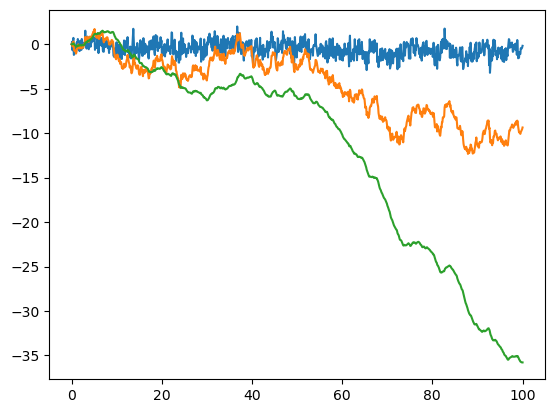

In [124]:
n_steps = 1024
T = 100

span = np.linspace(0, T, n_steps + 1)

out = simulate_fbm(1, n_steps, T, 0.05)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.5)
plt.plot(span, out.T)

out = simulate_fbm(1, n_steps, T, 0.95)
plt.plot(span, out.T)

# 1. MLE

In [125]:
np.loadtxt('/Users/james.male/Dissertation/fBMPath2.txt')

array([-0.05709538,  0.89753254, -0.67302038, ..., -0.7006463 ,
        1.6161513 ,  0.1552537 ])

In [51]:
4 ** 0.1 + 6 ** 0.1 - 2 * 5 ** 0.1

-0.015444159555729087